## Zeroth Step
### Importing Libraries and Loading Data

In [30]:
GC.gc() # Clear up the memory when doing a "run all" in the notebook

using Plots
gr()

include("src/load_profiles.jl")
include("src/solver.jl");

In [31]:
filename = "profiles.csv"
YEARS = [2015, 2016, 2017]
if !@isdefined(time_profiles)
    time_profiles, wind_profiles, solar_profiles = load_profiles(filename)
end;

### We first define the global parameters of the problem, to have consistent results across solving methods

In [32]:
# Default values
DEMAND = 1000. # Kg of H2
# Battery parameters
EBAT = 0.9 # per month discharge
FBAT = 100. # MW
COST_BAT = 250000 * 0.0002 # € / MWh
# Electrolyzer parameters
EELEC = 0.050 # Mwh / Kg
COST_ELEC =  1200000 * 0.0004 # € / MW
CAPA_ELEC_UPPER = 1000 # MW
# Tank parameters
COST_TANK = 407. # € / Kg
# Grid parameters
PRICE_GRID = 1000. # € / MWh
PRICE_CURTAILING = 500. # € / MWh;
PRICE_PENALITY = 0 # € / times changed
PRICE_PROD_CHANGE = 1 # € / kg of change in production level
# Renewable pricing, from https://atb.nrel.gov/electricity/2022/index
# For now : 20 year lifespan, no discount rate + O&M cost per year
COST_WIND = 1352 * 1000 / 20 + 43 * 1000 # € / MW
COST_SOLAR = 1233 * 1000 / 20 + 23 * 1000 # € / MW
# Upper bound on the battery capacity
CAPA_BAT_UPPER = 24 * DEMAND * EELEC # MW
#Year chosen for the simulation
YEAR = 2015;

In [33]:
function print_solution_propreties(
    output::Dict{String, Any}
)
    # Extract the solution values
    battery_capa = trunc(Int64, output["battery_capa"])
    tank_capa = trunc(Int64, output["tank_capa"])
    electro_capa = trunc(Int64, output["electro_capa"])
    wind_capa = trunc(Int64, output["wind_capa"])
    solar_capa = trunc(Int64, output["solar_capa"])
    storage_cost = output["storage_cost"]
    operating_cost = output["operating_cost"]
    electrolyser_cost = output["electrolyser_cost"]
    electricity_cost = output["electricity_plant_cost"]
    prod_out = output["prod"]
    charge_out = output["charge"]
    stock_out = output["stock"]
    elec_out = output["elecGrid"]
    curtailment_out = output["curtail"]
    consPPA_out = output["elecPPA"];
    # Capacities
    println("Battery capacity: $battery_capa MWh, Tank capacity: $tank_capa kg, Electrolyser capacity: $(electro_capa / EELEC) kg/h")
    println("Wind capacity: $wind_capa MW, Solar capacity: $solar_capa MW \n")
    # Energy Mix 
    mix_in_capacity = wind_capa / (wind_capa + solar_capa)
    mix_in_generation = wind_capa * sum(wind_profile) / (wind_capa * sum(wind_profile) + solar_capa * sum(solar_profile))
    println("Wind proportion in capacity: $mix_in_capacity \nWind proportion in generation: $mix_in_generation \n")
    # Total energy needed to run the electrolyser
    total_elec_needed = 8760 * DEMAND * EELEC
    total_elec_produced = trunc(sum(consPPA_out))
    total_elec_imported = trunc(sum(elec_out))
    total_elec_curtailment = trunc(sum(curtailment_out))
    println("Total electricity needed: $total_elec_needed MWh, Total electricity produced: $total_elec_produced MWh")
    println("Total electricity imported: $total_elec_imported MWh, Total electricity curtailment: $total_elec_curtailment MWh \n")
    println("Produced / Needed ratio : $(total_elec_produced / total_elec_needed) \n")
    # Costs
    println("Storage cost: $storage_cost, operating cost: $operating_cost")
    println("Electrolyser cost : $electrolyser_cost, electricity plant cost: $electricity_cost")
    println("Total cost: $(storage_cost + operating_cost + electrolyser_cost + electricity_cost)")

end;

In [34]:
function plot_solution(
    output::Dict
)
    # Extract the solution values
    battery_capa = trunc(Int64, output["battery_capa"])
    tank_capa = trunc(Int64, output["tank_capa"])
    electro_capa = trunc(Int64, output["electro_capa"])
    wind_capa = trunc(Int64, output["wind_capa"])
    solar_capa = trunc(Int64, output["solar_capa"])
    storage_cost = output["storage_cost"]
    operating_cost = output["operating_cost"]
    electrolyser_cost = output["electrolyser_cost"]
    electricity_cost = output["electricity_plant_cost"]
    prod_out = output["prod"]
    charge_out = output["charge"]
    stock_out = output["stock"]
    elec_out = output["elecGrid"]
    curtailment_out = output["curtail"]
    consPPA_out = output["elecPPA"];
    # Plot the production & tank charge over time
    prod = plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Production (Kg)",
    title="Hydrogen, Demand : $D kg/h, Electrolyser: $(electro_capa / EELEC) kg/h")
    plot!(prod, prod_out, label="Production")
    # Plot the consumptions, curtailment and battery charge
    cons = plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Electricity consumption (Mwh)",
    title="Consumption, Solar capacity: $(trunc(solar_capa)) MW, Wind capacity: $(trunc(wind_capa)) MW")
    plot!(cons, elec_out, label="Grid consumption")
    plot!(cons, consPPA_out, label="PPA consumption")
    plot!(cons, -curtailment_out, label="Curtailment")
    # Plot the charge levels
    level_bat = plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Battery charge (Mwh)",
     title="Battery charge level, Battery capacity : $battery_capa MWh")
    plot!(level_bat, charge_out, label="Battery charge")
    level_tank = plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Tank charge (Kg)",
     title="Tank charge level, Tank capacity : $tank_capa Kg")
    plot!(level_tank, stock_out, label="Tank charge")

    return prod, cons, level_bat, level_tank
end;

# First Step :
## Solve the problem given the production and storage capacities

In [35]:
# We use the default values for now
BAT_SIZE = 400. # MWh
TANK_SIZE = 500. # Kg
ELEC_CAPA = 1000. # MW
time_index = wind_profiles[YEAR]
wind_profile = wind_profiles[YEAR]
solar_profile = solar_profiles[YEAR]
# We decide on a mix of wind and solar
# For example, 25% of the energy comes from solar and 75% from wind
wind_share = 0.75
Total_energy_needed = D * length(wind_profile) * EELEC * 1.05 # in MWh, with a 5% safety margin
wind_capa = Total_energy_needed * wind_share / sum(wind_profile)
solar_capa = Total_energy_needed * (1 - wind_share) / sum(solar_profile);

In [36]:
output1 = solve(
    wind_profile, solar_profile, # WIND_PROFILE, SOLAR_PROFILE
    DEMAND, # DEMAND
    wind_capa, solar_capa, # WIND_CAPA, SOLAR_CAPA, if set to missing, the solver will optimize it
    BAT_SIZE, TANK_SIZE, ELEC_CAPA, # BAT_SIZE, TANK_SIZE, ELEC_CAPA, if set to missing, the solver will optimize it
    PRICE_GRID, PRICE_CURTAILING, # PRICE_GRID, PRICE_CURTAILING
    PRICE_PENALITY, PRICE_PROD_CHANGE, #PRICE_PENALITY, PRICE_PROD_CHANGE
    CAPA_BAT_UPPER, CAPA_ELEC_UPPER, # CAPA_BAT_UPPER, CAPA_ELEC_UPPER
    EBAT, FBAT, EELEC, # EBAT, FBAT, EELEC
    COST_ELEC, COST_BAT, COST_TANK, # COST_ELEC, COST_BAT, COST_TANK
    COST_WIND, COST_SOLAR, # COST_WIND, COST_SOLAR
    0., # No initial charge
    0., # No initial stock
    missing, # No final charge constraint
    missing, # No final stock constraint
);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-25
Adding variables ... 
Adding constraints ... 


Optimizing ...


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96366 rows, 87605 columns and 245281 nonzeros
Model fingerprint: 0x0fa3c8a0
Coefficient statistics:
  Matrix range     [5e-02, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e+00, 3e+07]
Presolve removed 70090 rows and 35051 columns
Presolve time: 0.12s
Presolved: 26276 rows, 52554 columns, 105102 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.882e+04
 Factor NZ  : 3.809e+05 (roughly 35 MB of memory)
 Factor Ops : 6.396e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
 

In [37]:
print_solution_propreties(output1)

Battery capacity: 400 MWh, Tank capacity: 500 kg, Electrolyser capacity: 20000.0 kg/h
Wind capacity: 179 MW, Solar capacity: 126 MW 

Wind proportion in capacity: 0.5868852459016394 
Wind proportion in generation: 0.7495463949939154 

Total electricity needed: 438000.0 MWh, Total electricity produced: 459899.0 MWh
Total electricity imported: 74921.0 MWh, Total electricity curtailment: 96289.0 MWh 

Produced / Needed ratio : 1.0499977168949772 

Storage cost: 223500.0, operating cost: 1.2306725378460114e8
Electrolyser cost : 480000.0, electricity plant cost: 3.0597923647564527e7
Total cost: 1.5436867743216565e8


In [38]:
prod1, cons1, bat1, tank1 = plot_solution(output1);

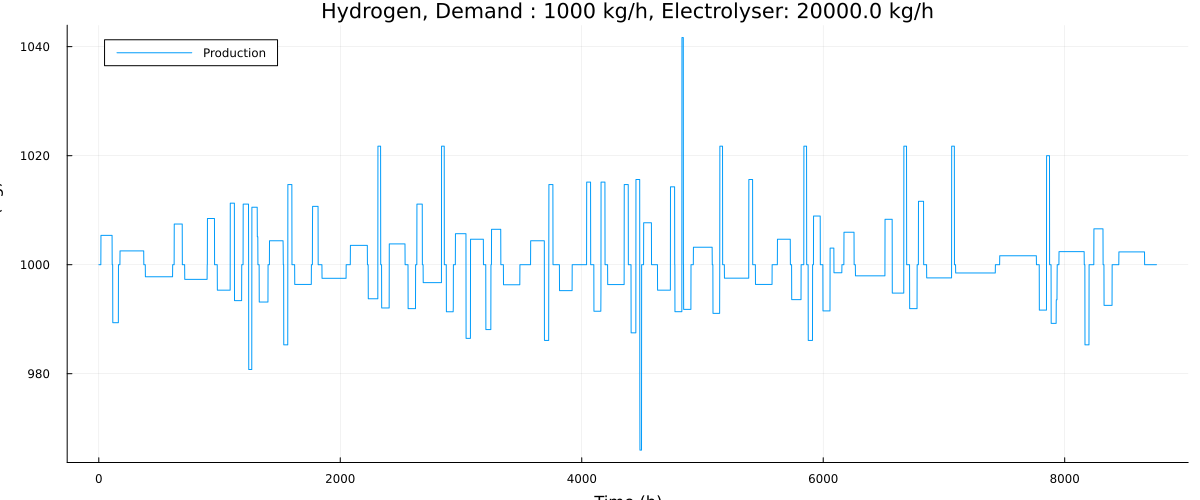

In [39]:
prod1

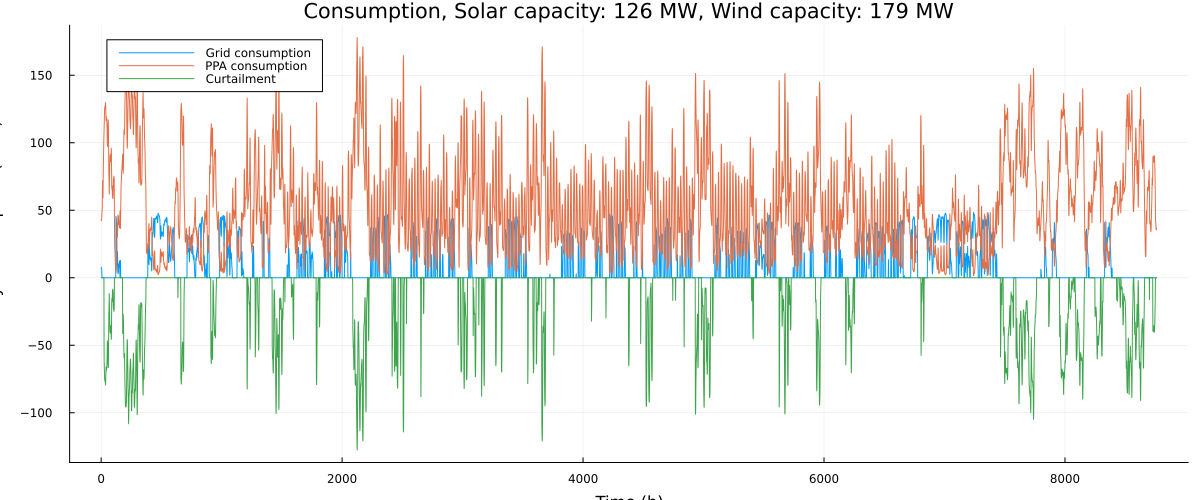

In [40]:
cons1

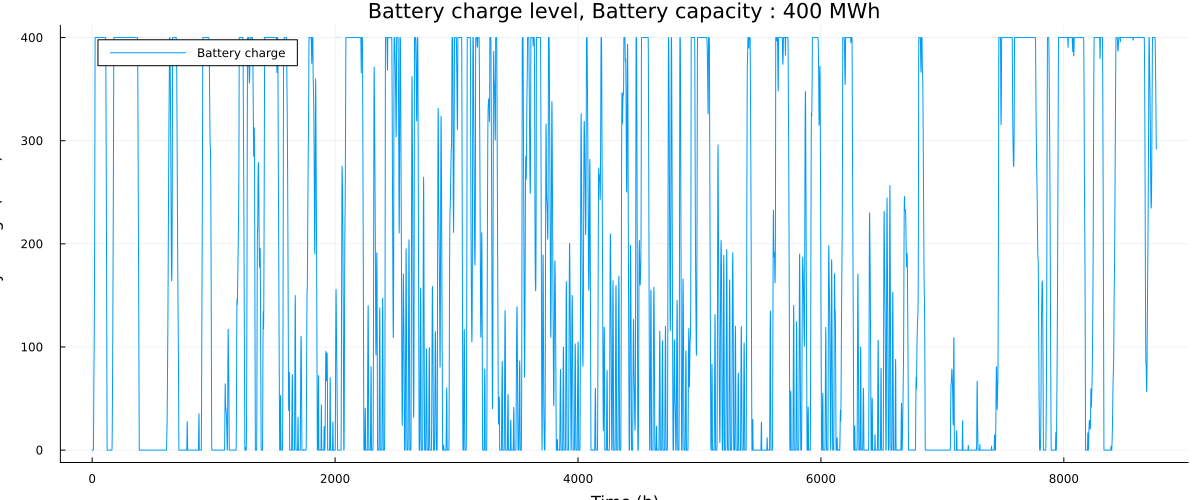

In [41]:
bat1

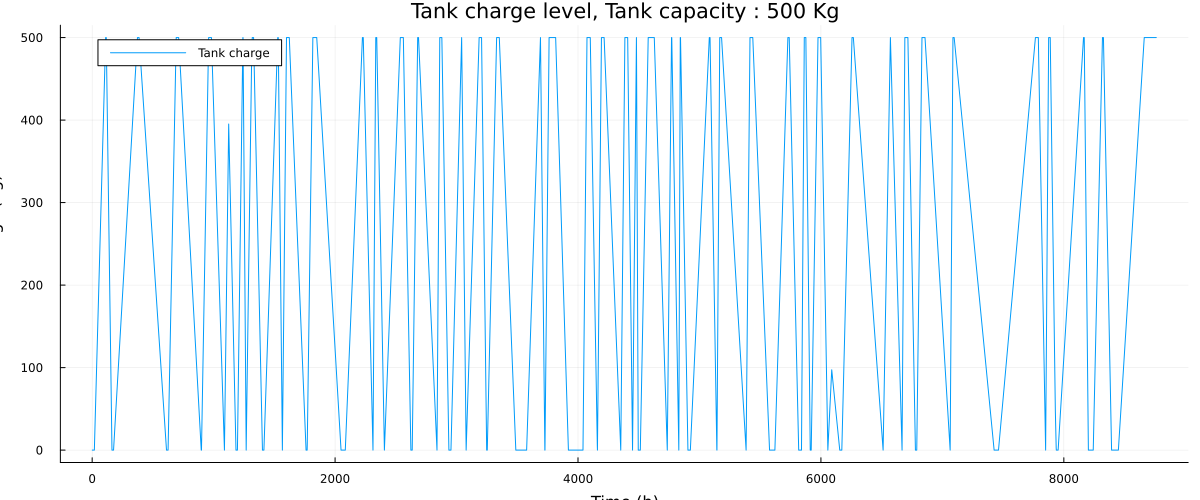

In [42]:
tank1

# Second Step :
## Solve the problem given the production capacities only

In [43]:
# We use the default values for now
D = 1000.
time_index = wind_profiles[YEAR]
wind_profile = wind_profiles[YEAR]
solar_profile = solar_profiles[YEAR]
# We decide on a mix of wind and solar
# For example, 25% of the energy comes from solar and 75% from wind
wind_share = 0.75
Total_energy_needed = D * length(wind_profile) * EELEC * 1.05 # in MWh, with a 5% safety margin
wind_capa = Total_energy_needed * wind_share / sum(wind_profile)
solar_capa = Total_energy_needed * (1 - wind_share) / sum(solar_profile);

In [44]:
output2 = solve(
    wind_profile, solar_profile, # WIND_PROFILE, SOLAR_PROFILE
    DEMAND, # DEMAND
    wind_capa, solar_capa, # WIND_CAPA, SOLAR_CAPA, if set to missing, the solver will optimize it
    missing, missing, missing, # BAT_SIZE, TANK_SIZE, ELEC_CAPA, if set to missing, the solver will optimize it
    PRICE_GRID, PRICE_CURTAILING, # PRICE_GRID, PRICE_CURTAILING
    PRICE_PENALITY, PRICE_PROD_CHANGE, #PRICE_PENALITY, PRICE_PROD_CHANGE
    CAPA_BAT_UPPER, CAPA_ELEC_UPPER, # CAPA_BAT_UPPER, CAPA_ELEC_UPPER
    EBAT, FBAT, EELEC, # EBAT, FBAT, EELEC
    COST_ELEC, COST_BAT, COST_TANK, # COST_ELEC, COST_BAT, COST_TANK
    COST_WIND, COST_SOLAR, # COST_WIND, COST_SOLAR
    0., # No initial charge
    0., # No initial stock
    missing, # No final charge constraint
    missing, # No final stock constraint
);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-25
Adding variables ... 
Adding constraints ... 


Optimizing ...


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96366 rows, 87608 columns and 271566 nonzeros
Model fingerprint: 0xeaf13a58
Coefficient statistics:
  Matrix range     [5e-02, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+02, 1e+03]
  RHS range        [1e+00, 3e+07]
Presolve removed 35050 rows and 26290 columns
Presolve time: 0.34s
Presolved: 18319 rows, 70077 columns, 237274 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 794
 AA' NZ     : 1.154e+05
 Factor NZ  : 2.725e+05 (roughly 40 MB of memory)
 Factor Ops : 4.396e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual   

In [45]:
print_solution_propreties(output2)

Battery capacity: 1200 MWh, Tank capacity: 46213 kg, Electrolyser capacity: 1700.0 kg/h
Wind capacity: 179 MW, Solar capacity: 126 MW 

Wind proportion in capacity: 0.5868852459016394 
Wind proportion in generation: 0.7495463949939154 

Total electricity needed: 438000.0 MWh, Total electricity produced: 459899.0 MWh
Total electricity imported: 33466.0 MWh, Total electricity curtailment: 51191.0 MWh 

Produced / Needed ratio : 1.0499977168949772 

Storage cost: 1.88688000655576e7, operating cost: 5.910961618483851e7
Electrolyser cost : 41186.07358368, electricity plant cost: 3.0597923647564527e7
Total cost: 1.0861752597154431e8


In [46]:
prod2, cons2, bat2, tank2 = plot_solution(output2);

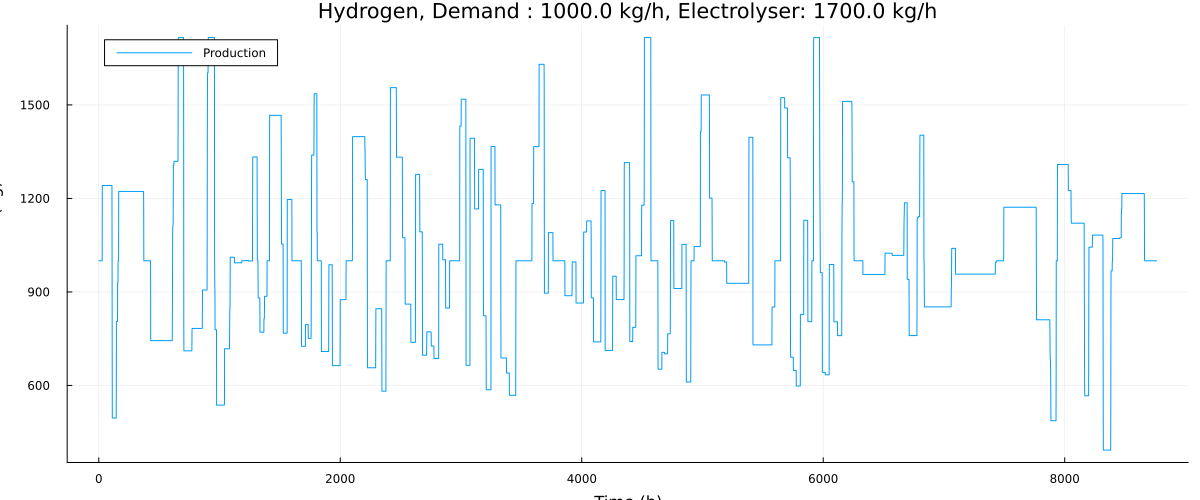

In [47]:
prod2

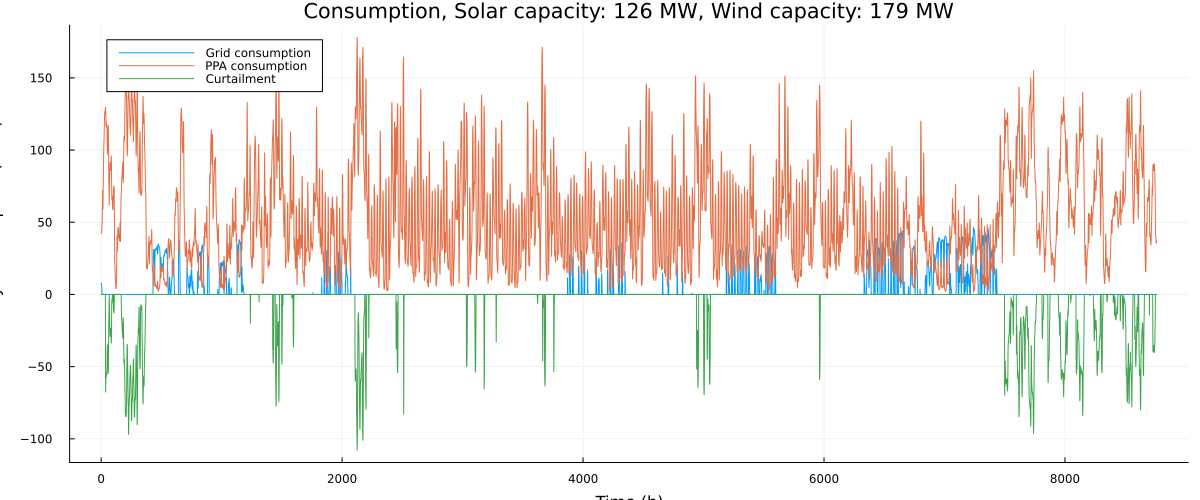

In [48]:
cons2

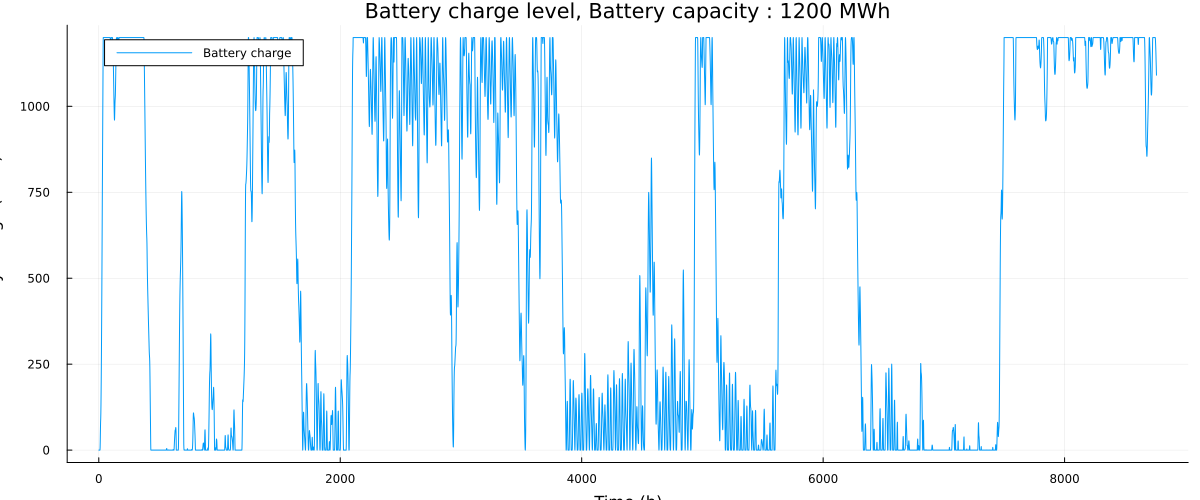

In [49]:
bat2

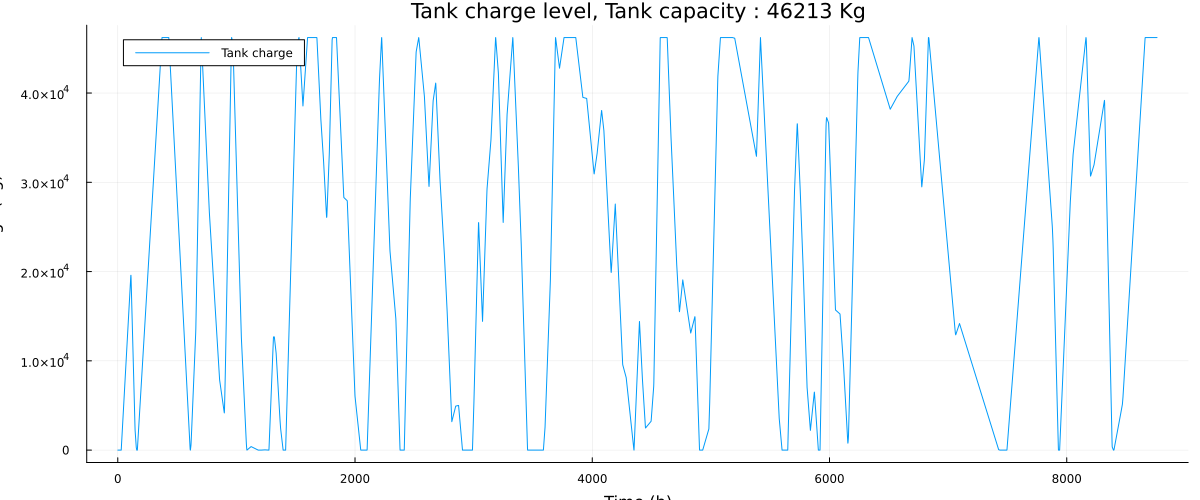

In [50]:
tank2

# Third Step : 
## Solve the problem given the demand only.

In [51]:
D = 1000.
time_index = wind_profiles[YEAR]
wind_profile = wind_profiles[YEAR]
solar_profile = solar_profiles[YEAR];

In [52]:
output3 = solve(
    wind_profile, solar_profile, # WIND_PROFILE, SOLAR_PROFILE
    DEMAND, # DEMAND
    missing, missing, # WIND_CAPA, SOLAR_CAPA, if set to missing, the solver will optimize the capacities
    missing, missing, missing, # BAT_SIZE, TANK_SIZE, ELEC_CAPA, if set to missing, the solver will optimize the capacities
    PRICE_GRID, PRICE_CURTAILING, # PRICE_GRID, PRICE_CURTAILING
    PRICE_PENALITY, PRICE_PROD_CHANGE, #PRICE_PENALITY, PRICE_PROD_CHANGE
    CAPA_BAT_UPPER, CAPA_ELEC_UPPER, # CAPA_BAT_UPPER, CAPA_ELEC_UPPER
    EBAT, FBAT, EELEC, # EBAT, FBAT, EELEC
    COST_ELEC, COST_BAT, COST_TANK, # COST_ELEC, COST_BAT, COST_TANK
    COST_WIND, COST_SOLAR, # COST_WIND, COST_SOLAR
    0., # No initial charge
    0., # No initial stock
    missing, # No final charge constraint
    missing, # No final stock constraint
);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-25
Adding variables ... 
Adding constraints ... 


Optimizing ...


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96366 rows, 87610 columns and 285214 nonzeros
Model fingerprint: 0xdddd7edc
Coefficient statistics:
  Matrix range     [1e-04, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+02, 1e+03]
  RHS range        [1e+03, 1e+03]
Presolve removed 35049 rows and 26288 columns
Presolve time: 0.37s
Presolved: 18321 rows, 70078 columns, 250922 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Free vars  : 792
 AA' NZ     : 1.431e+05
 Factor NZ  : 2.929e+05 (roughly 40 MB of memory)
 Factor Ops : 4.969e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual   

In [53]:
print_solution_propreties(output3)

Battery capacity: 1200 MWh, Tank capacity: 33165 kg, Electrolyser capacity: 1400.0 kg/h
Wind capacity: 131 MW, Solar capacity: 193 MW 

Wind proportion in capacity: 0.404320987654321 
Wind proportion in generation: 0.5884587949958902 

Total electricity needed: 438000.0 MWh, Total electricity produced: 427899.0 MWh
Total electricity imported: 37655.0 MWh, Total electricity curtailment: 24541.0 MWh 

Produced / Needed ratio : 0.9769383561643835 

Storage cost: 1.355825349974548e7, operating cost: 4.995569294152599e7
Electrolyser cost : 33998.92482141444, electricity plant cost: 3.0917603433481526e7
Total cost: 9.44655487995744e7


In [54]:
prod3, cons3, bat3, tank3 = plot_solution(output3);

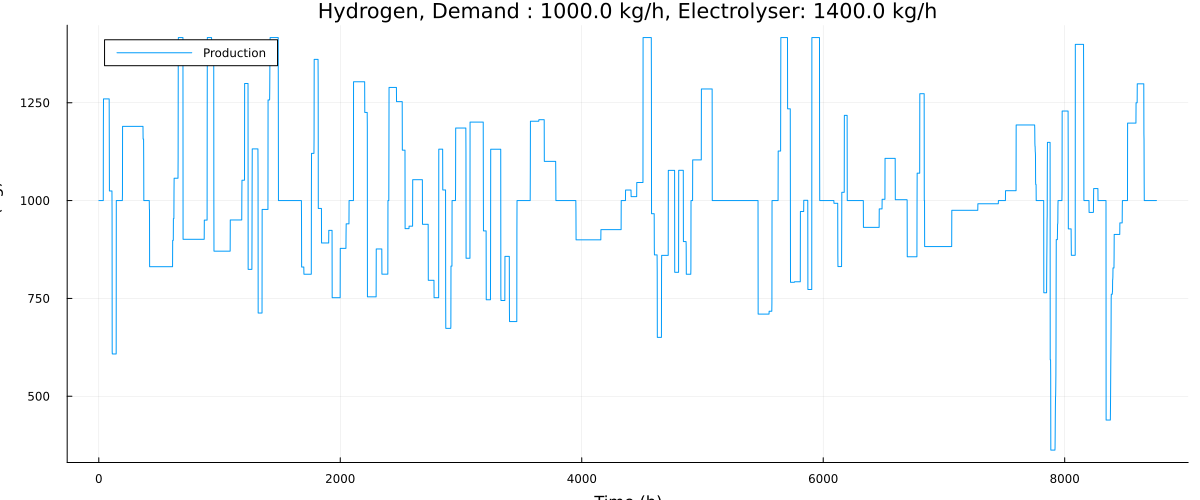

In [55]:
prod3

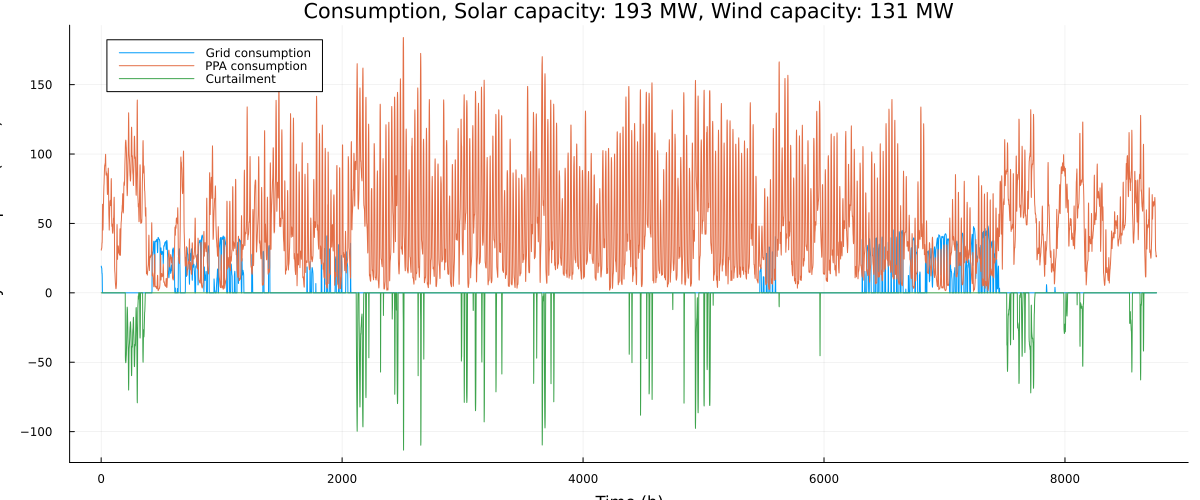

In [56]:
cons3

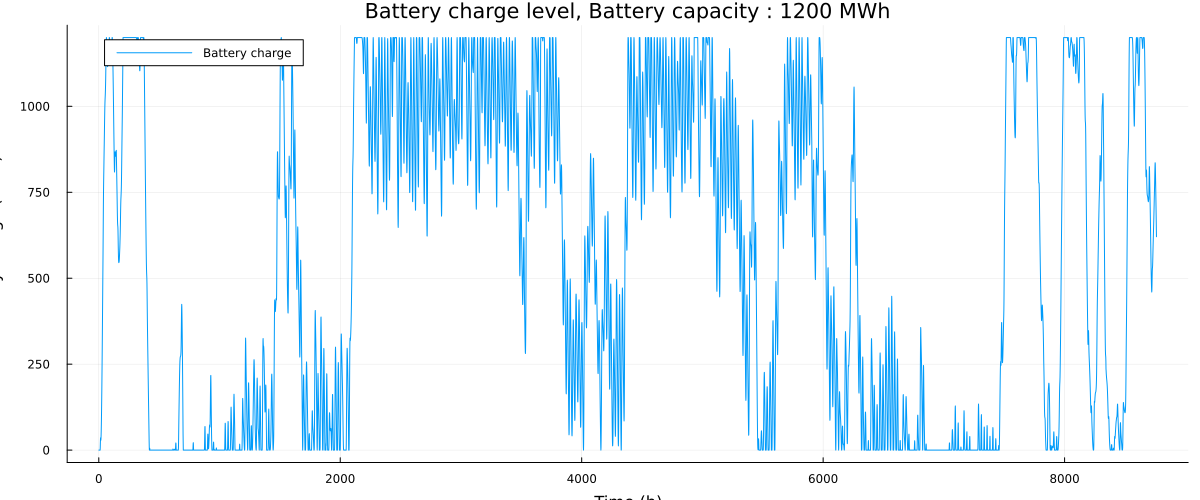

In [57]:
bat3

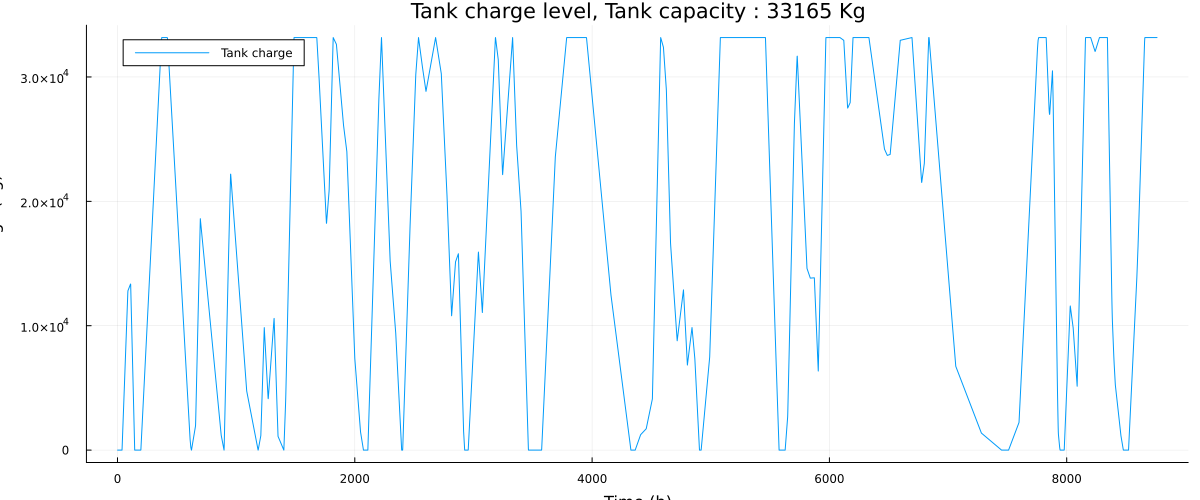

In [58]:
tank3